# Jupyter Notebook for Understanding LSTM Networks

This notebook is written for educational purposes to remove any remaining magic from LSTM networks by providing working examples of LSTMs in Numpy and providing additional visualizations. I recommend first reading Christopher Olah's wonderful blog post http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for a conceptual overview of LSTM networks. 

![LSTM3-chain.png](img/LSTM3-chain.png)

In [304]:
import numpy as np
import os
import seaborn as sb

# Seed random variables for reproducibility
os.environ['PYTHONHASHSEED'] = '1974'
np.random.seed(0)

# Activation Functions

Activation functions serve to apply non-linearity to the mapping of input to output, because a network consisting of only linear layers is equivalent to a 1-layer linear network. For this reason, in order to go deep we must apply non-linearities throughout the network. Below we define and visualize the non-linear activation functions used in vanilla implementations of LSTMs. For an extensive list of activation functions and their forumlae there is an excellent table at https://en.wikipedia.org/wiki/Activation_function.

## Sigmoid

The logistic sigmoid function has a mean, $\mu$ of 0 and std. dev. of 1. The sigmoid function is used in LSTMs as a way of scaling down some matrix, i.e. the parts that are important to the calculation with have values close to 1 (unchanged) and those that are unimportant have values close to 0 (ignored). 

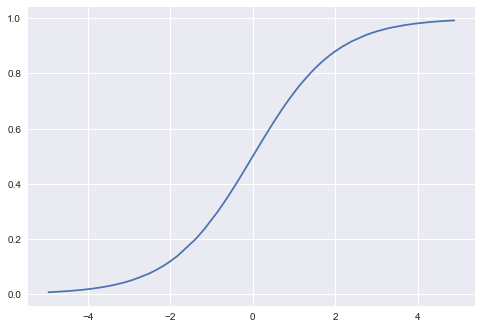

In [217]:
import numpy as np
from matplotlib import pyplot as plt

def sigmoid(x):
    return 1/(1 + np.exp(-x))

xs = sorted(np.random.uniform(-5, 5, size=100))
ys = [sigmoid(x) for x in xs]
plt.plot(xs, ys)
plt.show()

## Tanh

Hyperbolic tangent function has a range (-1, 1) with a mean, $\mu$ of 0.

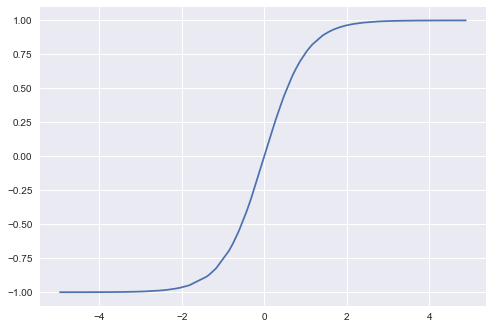

In [218]:
def tanh(x):
    return 2/(1 + np.exp(-2*x)) - 1

ys = [tanh(x) for x in xs]
plt.plot(xs, ys)
plt.show()

# Hyperparameters

These are parameters that we will tune using distributed methods later, right now think of them as arbitrary values that define the shape of our network.

In [243]:
embedding_dim = 3
hidden_dim = 4

# Parameters

In [220]:
sentence = "The quick brown fox jumps over the lazy dog"
#sentence = "All A B"
tokens = sentence.split(" ")

def initialize_parameters():
    word_embedding = np.random.rand(1, embedding_dim)
    hidden_state = np.random.rand(1, hidden_dim)
    cell_state = np.random.rand(1, hidden_dim)
    bias = np.zeros(1)
    
    return {"word_embedding": word_embedding, "hidden_state": hidden_state,
            "cell_state": cell_state, "bias": bias}

params = initialize_parameters()
print(params["word_embedding"])
print(params["hidden_state"])
print(params["cell_state"])

[[ 0.67781654  0.27000797  0.73519402]]
[[ 0.96218855  0.24875314  0.57615733  0.59204193]]
[[ 0.57225191  0.22308163  0.95274901  0.44712538]]


# LSTM
## Forget gate

![LSTM3-focus-f.png](img/LSTM3-focus-f.png)

In [310]:
W_f = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_f = np.zeros(1)

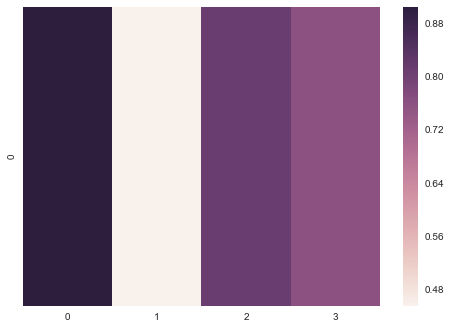

In [311]:
_input = np.concatenate((params["word_embedding"], params["hidden_state"]), axis=1)

def forget_gate(_input):
    # Compute forget gate via sigmoid function on affine map of input
    # make use of python broadcasting to add the bias vector across all vectors of the weighted input matrix
    forget_mask = sigmoid(np.dot(W_f, _input.T) + b_f)
    return forget_mask.T

sb.heatmap(forget_gate(_input))
plt.show()

As can be seen from the heatmap above, the point of the forget gate is to act as a mask on the cell state. Since the values are all between 0 and 1 (due to the sigmoid function), the result of element-wise multiplication with the cell state is a scaling down of each dimension and this scaling is a learnable parameter. Therefore, the LSTM learns to "forget" information at each time-step in a way that helps to optimize its loss function.

## Ignore Gate

![LSTM3-focus-i.png](img/LSTM3-focus-i.png)

In [246]:
W_i = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_i = np.zeros(1)

W_c = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
b_c = np.zeros(1)

In [247]:
def input_gate(_input):
    i = sigmoid(np.dot(W_i, _input.T) + b_i)
    c = tanh(np.dot(W_c, _input.T) + b_c)
    return (i * c).T

## Update Cell State

![LSTM3-focus-C.png](img/LSTM3-focus-C.png)

In [249]:
params["cell_state"] = forget_gate(_input) * params["cell_state"] + input_gate(_input)

In [250]:
params["cell_state"]

array([[ 0.31791415, -0.47202775, -0.05245668, -0.35293658]])

## Update Hidden State

![LSTM3-focus-o.png](img/LSTM3-focus-o.png)

In [268]:
def initialize_weights():
    W_f = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
    b_f = np.zeros(1)
    W_i = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
    b_i = np.zeros(1)
    W_c = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
    b_c = np.zeros(1)
    W_o = np.random.randn(hidden_dim, hidden_dim + embedding_dim)
    b_o = np.zeros(1)
    return {"W_f": W_f, "b_f": b_f, "W_i": W_i, "b_i": b_i, "W_c": W_c, "b_c": b_c, "W_o": W_o, "b_o": b_o}

In [269]:
def output_gate(_input):
    output_mask = sigmoid(np.dot(W_o, _input.T) + b_o)
    return output_mask.T

In [270]:
params["hidden_state"] = output_gate(_input) * tanh(params["cell_state"])

In [297]:
class LSTM:
    
    def __init__(self):
        self.output = []
        self.params = initialize_parameters()
        self.weights = initialize_weights()
    
    def forward(self, sentence):
        for word in sentence:
            word = word.reshape(1, embedding_dim)
            _input = np.concatenate((word, params["hidden_state"]), axis=1)
            self.params["cell_state"] = forget_gate(_input) * self.params["cell_state"] + input_gate(_input)
            self.params["hidden_state"] = output_gate(_input) * tanh(params["cell_state"])
            lstm.output.append(self.params["hidden_state"])
        return lstm.output
            
    def backward(self, loss):
        pass

In [312]:
lstm = LSTM()
sentence_length = 9
sentence_embedding = np.random.randn(sentence_length, embedding_dim)
output = lstm.forward(sentence_embedding)
output

[array([[ 0.24651796, -0.04319805, -0.04618423, -0.0195808 ]]),
 array([[ 0.12274976, -0.19756904, -0.01475074, -0.15357288]]),
 array([[ 0.02240677, -0.25504782, -0.00582843, -0.236839  ]]),
 array([[ 0.11993556, -0.39550655, -0.01132534, -0.24531068]]),
 array([[ 0.02683824, -0.13184024, -0.01610544, -0.14001233]]),
 array([[ 0.00727268, -0.01560344, -0.00756463, -0.11488483]]),
 array([[ 0.187246  , -0.29033826, -0.02052258, -0.15309559]]),
 array([[ 0.12608357, -0.01215371, -0.02768689, -0.03646047]]),
 array([[ 0.12777314, -0.0642075 , -0.02834242, -0.06529254]])]

In [316]:
matrix = np.array(output).reshape(sentence_length, hidden_dim)
matrix.shape

(9, 4)

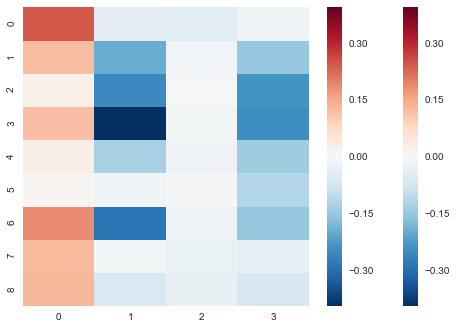

In [318]:
sb.heatmap(matrix)
plt.show()

In [320]:
def loss_func(y, y_hat):
    """ Implements Binary Cross Entropy Loss Function"""
    return -np.sum(y * np.log(y_hat))

In [327]:
loss_func([0.8], [0.3])

0.96317824346074898

# Pytorch

In [2]:
import torch
import torch.autograd as autograd

In [3]:
class LSTM:
    
    def __init__(self):
        pass
    
    def forward(self, sentence):
        embedding = self.embedding(sentence)
        lstm_out, (self.hidden, self.cell_state) = self.lstm(embedding)